In [1]:
import numpy as np
import logging
from scipy.io.matlab import loadmat
from scipy.sparse import csr_matrix
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, mean_squared_error

import rescal
from brescal import BayesianRescal
from seq_brescal import PFBayesianRescal

%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
mat = loadmat('../data/alyawarradata.mat')
T = np.array(mat['Rs'], np.float32)

n_dim = 10
max_iter = 5000
T = np.swapaxes(T, 1, 2)
T = np.swapaxes(T, 0, 1)  # [relation, entity, entity]
n_relation, n_entity, _ = T.shape
print('Tensor dimension: %s' % (str(T.shape)))
print('Tensor size: %d' % (np.prod(T.shape)))
print('Total population: %d' % (np.sum(T)))
print('Proportion of true value %.3f' % (np.sum(T)/np.prod(T.shape)))

Tensor dimension: (26, 104, 104)
Tensor size: 281216
Total population: 10790
Proportion of true value 0.038


In [3]:
import itertools
maskT = np.zeros_like(T)
p = 0.1
for k in range(n_relation):
    for i,j in itertools.product(range(n_entity),repeat=2):
        if T[k, i, j] and np.random.binomial(1, p):
            maskT[k, i, j] = 1
            
print('Number of initial positive observation %d' % (np.sum(maskT)))

#maskT = np.ones_like(T)  #fully observed
#set negative tripes to -1
#T[T==0] = -1

Number of initial positive observation 1036


In [4]:
model = PFBayesianRescal(n_dim, var_x = 0.01, controlled_var=False, n_particles=1, mc_move=1, 
                         compute_score=True, eval_fn=mean_squared_error, parallelize=True, sample_prior=False)
seq = model.fit(T, obs_mask = maskT.copy(), max_iter=max_iter)

INFO:seq_brescal:[NEXT] (25, 41, 23): 0.000, population: 0/1
INFO:seq_brescal:[  0] LL: 332640.903 | fit(mean_squared_error): 0.00369 |  sec: 0.366
INFO:seq_brescal:[NEXT] (11, 103, 102): 0.000, population: 0/2
INFO:seq_brescal:[  1] LL: 332794.085 | fit(mean_squared_error): 0.00369 |  sec: 0.372
INFO:seq_brescal:[NEXT] (16, 103, 23): 0.000, population: 0/3
INFO:seq_brescal:[  2] LL: 332840.812 | fit(mean_squared_error): 0.00369 |  sec: 0.404
INFO:seq_brescal:[NEXT] (7, 28, 23): 0.000, population: 0/4
INFO:seq_brescal:[  3] LL: 332911.795 | fit(mean_squared_error): 0.00368 |  sec: 0.413
INFO:seq_brescal:[NEXT] (9, 103, 89): 0.000, population: 0/5
INFO:seq_brescal:[  4] LL: 333078.829 | fit(mean_squared_error): 0.00367 |  sec: 0.387
INFO:seq_brescal:[NEXT] (15, 96, 70): 0.000, population: 0/6
INFO:seq_brescal:[  5] LL: 333334.934 | fit(mean_squared_error): 0.00365 |  sec: 0.353
INFO:seq_brescal:[NEXT] (16, 45, 26): 0.000, population: 0/7
INFO:seq_brescal:[  6] LL: 333621.915 | fit(mean_

In [5]:
model = PFBayesianRescal(n_dim, var_x = 0.01, controlled_var=False, n_particles=1, mc_move=1, rbp=True,
                         compute_score=True, eval_fn=mean_squared_error, parallelize=True, sample_prior=False)
seq2 = model.fit(T, obs_mask = maskT.copy(), max_iter=max_iter)

INFO:seq_brescal:[NEXT] (16, 11, 75): 0.000, population: 0/1
INFO:seq_brescal:[  0] LL: 332677.464 | fit(mean_squared_error): 0.00368 |  sec: 0.558
INFO:seq_brescal:[NEXT] (13, 90, 103): 0.000, population: 0/2
INFO:seq_brescal:[  1] LL: 332808.208 | fit(mean_squared_error): 0.00366 |  sec: 0.555
INFO:seq_brescal:[NEXT] (11, 103, 36): 0.000, population: 0/3
INFO:seq_brescal:[  2] LL: 332929.805 | fit(mean_squared_error): 0.00365 |  sec: 0.538
INFO:seq_brescal:[NEXT] (8, 103, 5): 1.000, population: 1/4
INFO:seq_brescal:[  3] LL: 333090.342 | fit(mean_squared_error): 0.00364 |  sec: 0.536
INFO:seq_brescal:[NEXT] (16, 10, 103): 1.000, population: 2/5
INFO:seq_brescal:[  4] LL: 333456.990 | fit(mean_squared_error): 0.00361 |  sec: 0.561
INFO:seq_brescal:[NEXT] (15, 10, 70): 1.000, population: 3/6
INFO:seq_brescal:[  5] LL: 333592.702 | fit(mean_squared_error): 0.00359 |  sec: 0.544
INFO:seq_brescal:[NEXT] (15, 67, 70): 1.000, population: 4/7
INFO:seq_brescal:[  6] LL: 333749.596 | fit(mean_

## Populate using RESCAL

In [12]:
trainT = T.copy()
trainT[maskT==0] = 0
mask = maskT.copy()

X = list()
for k in range(n_relation):
    X.append(csr_matrix(trainT[k]))

handlers = logger.handlers
[logger.removeHandler(handle) for handle in handlers]

seq4 = list()
for i in range(max_iter):
    A, R, f, itr, exectimes = rescal.rescal_als(X, n_dim)
    _X = np.zeros_like(T)
    for k in range(T.shape[0]):
        _X[k] = np.dot(np.dot(A, R[k]), A.T)
    find = False
    while not find:
        _X[mask==1] = -10000
        next_idx = np.unravel_index(_X.argmax(), T.shape)
        mask[next_idx] = 1
        seq4.append(next_idx)
        if T[next_idx] == 1:
            X[next_idx[0]][next_idx[1],next_idx[2]] = T[next_idx]
            find = True
        if len(seq4) == max_iter:
            break
    if len(seq4) == max_iter:
        break

[logger.addHandler(handle) for handle in handlers]    

/Users/arongdari/.python3/lib/python3.4/site-packages/scipy/sparse/compressed.py:739: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


[]

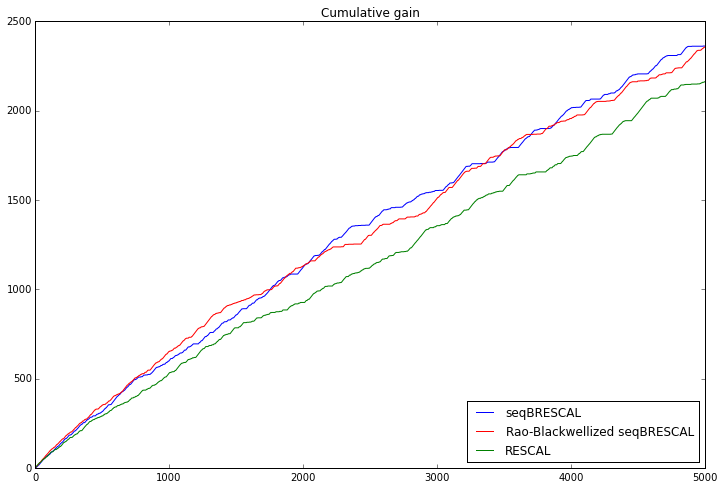

In [50]:
x = range(len(seq))
y = np.cumsum([T[s] for s in seq])
z = np.cumsum([T[s] for s in seq2])
r = np.cumsum([T[s] for s in seq4])

fig = plt.figure(figsize=(12,8))
plt.plot(x,y, color='blue', label='seqBRESCAL')
plt.plot(x,z, color='red', label='Rao-Blackwellized seqBRESCAL')
plt.plot(x,r, color='green', label='RESCAL')
plt.title('Cumulative gain')
plt.legend(loc=4)
plt.show()

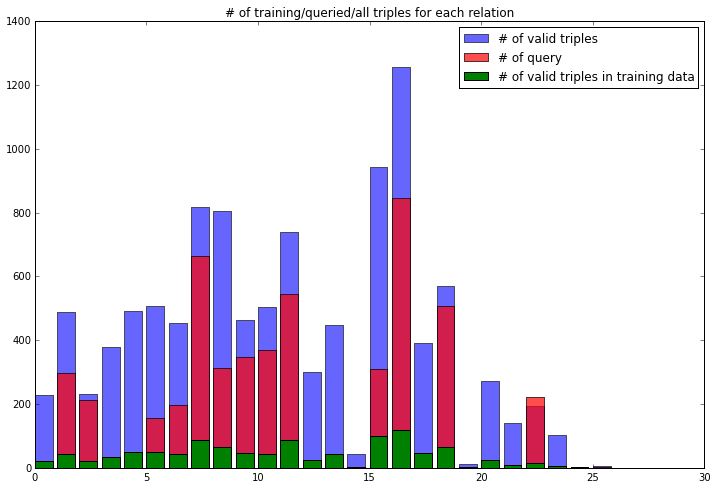

26


In [51]:
count = np.zeros(n_relation)
count2 = [np.sum(T[k]) for k in range(n_relation)]
count3 = [np.sum(maskT[k]) for k in range(n_relation)]
for s in seq:
    count[s[0]]+=1

fig = plt.figure(figsize=(12,8))
plt.bar(range(n_relation), count2, alpha=0.6, color='blue', label='# of valid triples')
plt.bar(range(n_relation), count, alpha=0.7, color='red', label='# of query')
plt.bar(range(n_relation), count3, alpha=1, color='green', label='# of valid triples in training data')
plt.legend(loc=0)
plt.title('# of training/queried/all triples for each relation')
plt.show()
print(n_relation)